<a href="https://colab.research.google.com/github/nati-curious/EPAM-University-Data-Science-Program/blob/main/linear_regression_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import frameworks and libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
import io
from google.colab import files
warnings.filterwarnings('ignore')

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge, Lasso,
    ElasticNet,
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    GridSearchCV,
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import (
    DataFrameMapper,
    gen_features,
)
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
from sklearn.base import clone
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
# Commonly used constants
SEED = 42
TARGET = 'C6H6(GT)'

# Helper functions

In [ ]:
# Plot a linear regression moodel fit
def regression_fit(x, y, df):
    ax = sns.regplot(x=x, y=y, data=df)
    ax.set_title(f'{y} and {x} relationship')
    return ax

In [ ]:
# Plot feature importance visualization
def plot_importance(est, colnames, top_n=11):
    importance = pd.DataFrame({
        'abs_weight': np.abs(est.coef_),
        'feature': colnames
    })
    imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
    sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h');

In [ ]:
# Evaluate model
def evaluate_model(train, test, y_train, y_test, pipeline):
    pipeline.fit(train, y_train)
    pred_test = pipeline.predict(test)
    pred_train = pipeline.predict(train)
    mapper = pipeline.named_steps['mapper']

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(y_train, pred_train))],
        'train_R2': [r2_score(y_train, pred_train)],
        'test_RMSE': [np.sqrt(mean_squared_error(y_test, pred_test))],
        'test_R2': [r2_score(y_test, pred_test)]
    }), mapper.transformed_names_, pred_test


# EDA & Data Preparation

[Air Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Air+Quality#) contains 9,358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level, within an Italian city. Data were recorded from March 2004 to February 2005 (one year) representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.

In [ ]:
# Check a CSV file
data = pd.read_csv('/content/drive/MyDrive/AirQualityUCI.csv', delimiter=';', decimal='.')
data

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
0     10/03/2004  18.00.00    2,6       1360.0     150.0     11,9   
1     10/03/2004  19.00.00      2       1292.0     112.0      9,4   
2     10/03/2004  20.00.00    2,2       1402.0      88.0      9,0   
3     10/03/2004  21.00.00    2,2       1376.0      80.0      9,2   
4     10/03/2004  22.00.00    1,6       1272.0      51.0      6,5   
...          ...       ...    ...          ...       ...      ...   
9466         NaN       NaN    NaN          NaN       NaN      NaN   
9467         NaN       NaN    NaN          NaN       NaN      NaN   
9468         NaN       NaN    NaN          NaN       NaN      NaN   
9469         NaN       NaN    NaN          NaN       NaN      NaN   
9470         NaN       NaN    NaN          NaN       NaN      NaN   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0            1046.0    166.0        1056.0    113.0        1692.0   
1             955.0    103.0        1174.0     92.0        1559.0   
2             939.0    131.0        1140.0    114.0        1555.0   
3             948.0    172.0        1092.0    122.0        1584.0   
4             836.0    131.0        1205.0    116.0        1490.0   
...             ...      ...           ...      ...           ...   
9466            NaN      NaN           NaN      NaN           NaN   
9467            NaN      NaN           NaN      NaN           NaN   
9468            NaN      NaN           NaN      NaN           NaN   
9469            NaN      NaN           NaN      NaN           NaN   
9470            NaN      NaN           NaN      NaN           NaN   

      PT08.S5(O3)     T    RH      AH  Unnamed: 15  Unnamed: 16  
0          1268.0  13,6  48,9  0,7578          NaN          NaN  
1           972.0  13,3  47,7  0,7255          NaN          NaN  
2          1074.0  11,9  54,0  0,7502          NaN          NaN  
3          1203.0  11,0  60,0  0,7867          NaN          NaN  
4          1110.0  11,2  59,6  0,7888          NaN          NaN  
...           ...   ...   ...     ...          ...          ...  
9466          NaN   NaN   NaN     NaN          NaN          NaN  
9467          NaN   NaN   NaN     NaN          NaN          NaN  
9468          NaN   NaN   NaN     NaN          NaN          NaN  
9469          NaN   NaN   NaN     NaN          NaN          NaN  
9470          NaN   NaN   NaN     NaN          NaN          NaN  

[9471 rows x 17 columns]

There are 5 elements with ground truth measurements that were provided by a certified analyzer:

CO(GT) - cobalt,\
NMHC(GT) - non metanic hydrocarbons,\
C6H6(GT) - benzene,\
NOx(GT) - total nitrogen oxides,\
NO2(GT) - nitrogen dioxide.

Also we have measurements of:\
T - temperature,\
RH - relative humidity (depends on the temperature of air; on increasing temperature, relative humidity decreases),\
AH - absolute humidity (measure of the actual amount of water vapor (moisture) in the air, regardless of the air's temperature).

Our target is to predict Benzene metrics.

In the dataset there are metrics obtained by sensor:\
PT08.S1(CO),\
PT08.S2(NMHC),\
PT08.S3(NOx),\
PT08.S4(NO2),\
PT08.S5(O3).

We don't have sensor measurement for our target chemical element benzene - C6H6(GT).\
We don't have ground truth measurement for ozone (O3).

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [ ]:
# Check for NA values
data.isna().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [ ]:
data.min()

PT08.S1(CO)     -200.0
NMHC(GT)        -200.0
PT08.S2(NMHC)   -200.0
NOx(GT)         -200.0
PT08.S3(NOx)    -200.0
NO2(GT)         -200.0
PT08.S4(NO2)    -200.0
PT08.S5(O3)     -200.0
Unnamed: 15        NaN
Unnamed: 16        NaN
dtype: float64

In [ ]:
data.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
Unnamed: 15      float64
Unnamed: 16      float64
dtype: object

* Numerical data is propmpted as objects that indicates the data is messy.
* 'Unnamed: 15' and 'Unnamed: 16' columns contain only NaN values.
* There is no '-200' values, only '-200.0' (maybe it is misleading description or maybe it is untidy dataset).
* In the dataset description it is said that the dataset contains 9358 instances. CSV contains 9471 samples. I suppose 'additional' rows contains NA values that we can see in the tail of the table.

Let's check an XLSX file.

In [ ]:
uploaded = files.upload()

df = pd.read_excel(io.BytesIO(uploaded.get('AirQualityUCI.xlsx')))
df.head()

Saving AirQualityUCI.xlsx to AirQualityUCI.xlsx


Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000  0.750239  
3  11.00  60.000000  0.786713  
4  11.15  59.575001  0.788794

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [ ]:
df.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [ ]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

Dataset in the XLSX file contains data in an appropriate format.

In [ ]:
df.min()

Date             2004-03-10 00:00:00
Time                        00:00:00
CO(GT)                        -200.0
PT08.S1(CO)                   -200.0
NMHC(GT)                        -200
C6H6(GT)                      -200.0
PT08.S2(NMHC)                 -200.0
NOx(GT)                       -200.0
PT08.S3(NOx)                  -200.0
NO2(GT)                       -200.0
PT08.S4(NO2)                  -200.0
PT08.S5(O3)                   -200.0
T                             -200.0
RH                            -200.0
AH                            -200.0
dtype: object

In an XLSX file there are more features with minimum values than in a CSV file. We are especially interested in '-200' values that are perhaps strings in CSV file.\
Let's work with the XLSX file because it is more tidy.

In [ ]:
# Check for missing values
df.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [ ]:
# Check for duplicates
df.duplicated().sum()

0

It seems missing values are tagged not only as -200 but also as -200.0. Let's check how many each column has this type of values.

In [ ]:
df['CO(GT)'].value_counts()

-200.0    1683
 1.0       305
 1.4       279
 1.6       275
 1.5       273
          ... 
 9.9         1
 7.6         1
 9.3         1
 7.0         1
 8.5         1
Name: CO(GT), Length: 97, dtype: int64

In [ ]:
df['PT08.S1(CO)'].value_counts()

-200.000000     366
 1099.500000     12
 954.250000      12
 986.750000      12
 888.000000      11
               ... 
 808.000000       1
 834.333333       1
 891.666667       1
 748.500000       1
 1314.250000      1
Name: PT08.S1(CO), Length: 3246, dtype: int64

In [ ]:
df['NMHC(GT)'].value_counts()

-200    8443
 66       14
 40        9
 29        9
 88        8
        ... 
 422       1
 424       1
 339       1
 445       1
 307       1
Name: NMHC(GT), Length: 430, dtype: int64

In [ ]:
df['C6H6(GT)'].value_counts()

-200.000000    366
 6.849892       13
 10.184263       9
 5.560496        9
 4.045717        9
              ... 
 26.798408       1
 18.833976       1
 21.837693       1
 21.275833       1
 1.307608        1
Name: C6H6(GT), Length: 3773, dtype: int64

In [ ]:
df['PT08.S2(NMHC)'].value_counts()

-200.000000     366
 850.250000      13
 984.500000       9
 791.000000       9
 713.250000       9
               ... 
 1474.000000      1
 1263.500000      1
 1346.666667      1
 1331.500000      1
 528.000000       1
Name: PT08.S2(NMHC), Length: 3773, dtype: int64

In [ ]:
df['NOx(GT)'].value_counts()

-200.0    1639
 65.0       37
 89.0       36
 41.0       36
 57.0       32
          ... 
 450.9       1
 564.7       1
 715.8       1
 794.1       1
 353.3       1
Name: NOx(GT), Length: 2467, dtype: int64

In [ ]:
df['PT08.S3(NOx)'].value_counts()

-200.00     366
 829.50      11
 866.25      10
 683.25      10
 844.50       9
           ... 
 1429.25      1
 1587.25      1
 1056.50      1
 637.25       1
 414.75       1
Name: PT08.S3(NOx), Length: 3519, dtype: int64

In [ ]:
df['NO2(GT)'].value_counts()

-200.0    1642
 97.0       68
 95.0       66
 101.0      65
 114.0      63
          ... 
 290.6       1
 275.9       1
 249.8       1
 251.2       1
 167.7       1
Name: NO2(GT), Length: 1420, dtype: int64

In [ ]:
df['PT08.S4(NO2)'].value_counts()

-200.00     366
 1490.00     10
 1363.00      9
 1479.25      8
 1533.50      8
           ... 
 1123.25      1
 2185.00      1
 2165.50      1
 1370.25      1
 987.00       1
Name: PT08.S4(NO2), Length: 4408, dtype: int64

In [ ]:
df['PT08.S5(O3)'].value_counts()

-200.00     366
 825.75      10
 904.50       8
 779.00       8
 835.50       8
           ... 
 663.75       1
 593.25       1
 610.50       1
 410.00       1
 1269.00      1
Name: PT08.S5(O3), Length: 4679, dtype: int64

In [ ]:
df['T'].value_counts()

-200.000000    366
 23.050000      15
 15.050000      15
 24.000000      13
 20.800000      13
              ... 
 36.849999       1
 36.325001       1
 35.825001       1
 32.150000       1
 28.500000       1
Name: T, Length: 3368, dtype: int64

In [ ]:
df['RH'].value_counts()

-200.000000    366
 47.750000      11
 51.450000       9
 49.675000       8
 55.950000       8
              ... 
 55.474999       1
 61.750000       1
 25.600000       1
 26.350000       1
 18.350000       1
Name: RH, Length: 4903, dtype: int64

In [ ]:
df['AH'].value_counts()

-200.000000    366
 1.471326        2
 0.779770        2
 0.705801        2
 1.320841        2
              ... 
 1.082815        1
 1.011949        1
 0.909946        1
 1.004462        1
 0.502804        1
Name: AH, Length: 8988, dtype: int64

In [ ]:
# Replace '-200' and '-200.0' with NaN for futher work and decisions
df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', \
    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']] \
    = df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', \
    'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]. \
    replace([-200, -200.0], np.NaN)
df.isnull().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [ ]:
# Calculate percentage of NA values in C6H6(GT) column
C6H6GT_ratio = df['C6H6(GT)'].isna().sum()/len(df['C6H6(GT)'])
C6H6GT_ratio

0.0391151009939083

In [ ]:
# Remove rows with NA values in a target variable to keep it 0% synthetic
df.drop(df[df['C6H6(GT)'].isna()].index, axis = 0, inplace = True)

In [ ]:
# Drop rows with all NA values (if there are any)
df = df.dropna(how='all')
df.shape

(8991, 15)

There is no rows with all NaN values.

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# Calculate percentage of NA values in NMHC(GT) column
NMHC_ratio = df['NMHC(GT)'].isna().sum()/len(df['NMHC(GT)'])
NMHC_ratio

0.9013457902346791

In [ ]:
# Since 90% of NMHC(GT) column's values is NA drop this column
df = df.drop('NMHC(GT)', axis=1)

In [ ]:
# Combine Date and Time columns for further data wrangling
new_df = pd.to_datetime(df.Date.astype(str) + ' ' +df.Time.astype(str))
df.insert(2, 'DateTime', new_df)
df = df.drop(['Date', 'Time'], axis=1)
df.reset_index(drop=True)
df.head()

DateTime  CO(GT)  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10 18:00:00     2.6      1360.00  11.881723        1045.50    166.0   
1 2004-03-10 19:00:00     2.0      1292.25   9.397165         954.75    103.0   
2 2004-03-10 20:00:00     2.2      1402.00   8.997817         939.25    131.0   
3 2004-03-10 21:00:00     2.2      1375.50   9.228796         948.25    172.0   
4 2004-03-10 22:00:00     1.6      1272.25   6.518224         835.50    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)      T         RH  \
0       1056.25    113.0       1692.00      1267.50  13.60  48.875001   
1       1173.75     92.0       1558.75       972.25  13.30  47.700000   
2       1140.00    114.0       1554.50      1074.00  11.90  53.975000   
3       1092.00    122.0       1583.75      1203.25  11.00  60.000000   
4       1205.00    116.0       1490.00      1110.00  11.15  59.575001   

         AH  
0  0.757754  
1  0.725487  
2  0.750239  
3  0.786713  
4  0.788794

Let's change indices of the dataframe to a Date column to later fill missing values with 'time' parameter of interpolation method and dividing the dataset as Time Series.

In [ ]:
# Make a Date column an index
df.set_index('DateTime', inplace=True)
df.tail()

CO(GT)  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
DateTime                                                                      
2005-04-04 10:00:00     3.1      1314.25  13.529605        1101.25    471.7   
2005-04-04 11:00:00     2.4      1162.50  11.355157        1027.00    353.3   
2005-04-04 12:00:00     2.4      1142.00  12.374538        1062.50    293.0   
2005-04-04 13:00:00     2.1      1002.50   9.547187         960.50    234.5   
2005-04-04 14:00:00     2.2      1070.75  11.932060        1047.25    265.2   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       T  \
DateTime                                                                        
2005-04-04 10:00:00        538.50    189.8       1374.25      1728.50  21.850   
2005-04-04 11:00:00        603.75    179.2       1263.50      1269.00  24.325   
2005-04-04 12:00:00        603.25    174.7       1240.75      1092.00  26.900   
2005-04-04 13:00:00        701.50    155.7       1041.00       769.75  28.325   
2005-04-04 14:00:00        654.00    167.7       1128.50       816.00  28.500   

                         RH        AH  
DateTime                               
2005-04-04 10:00:00  29.250  0.756824  
2005-04-04 11:00:00  23.725  0.711864  
2005-04-04 12:00:00  18.350  0.640649  
2005-04-04 13:00:00  13.550  0.513866  
2005-04-04 14:00:00  13.125  0.502804

## Multivariate analysis

### Feature correlation

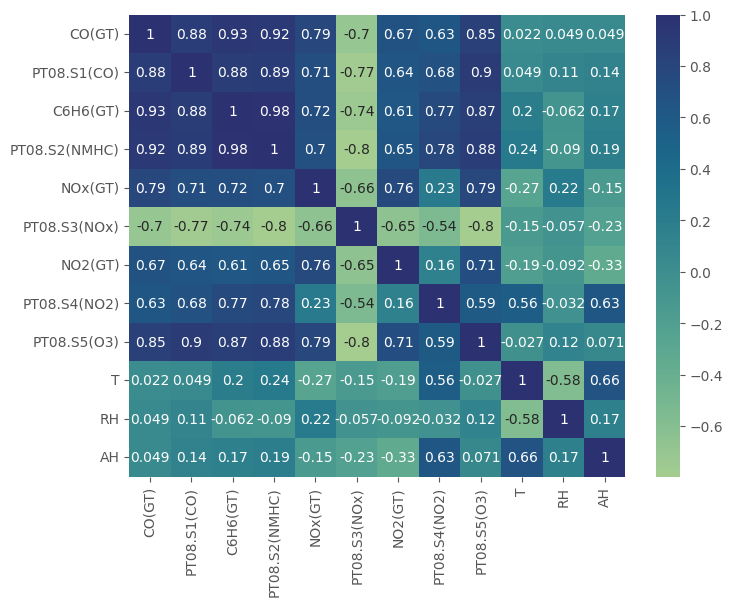

In [ ]:
# Plot heatmap
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="crest");

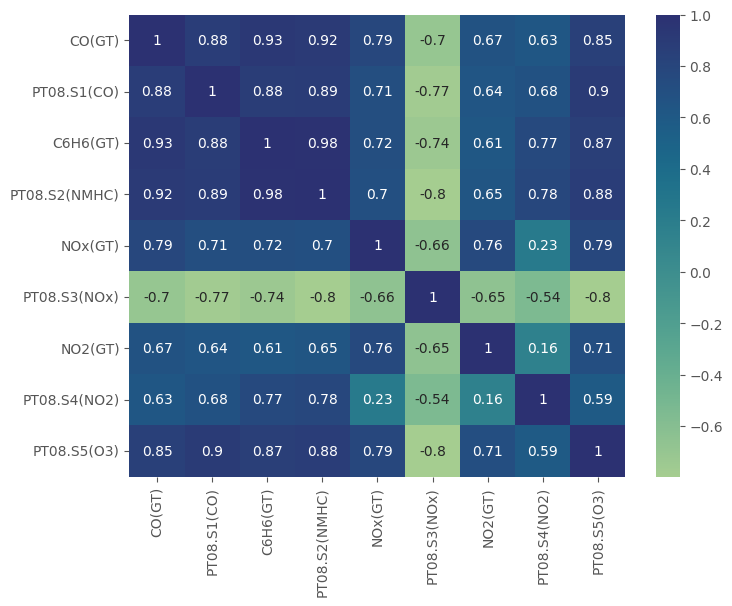

In [ ]:
# Plot heatmap of only strongly correlated features
corr = df.corr()
condition = np.abs(corr[TARGET]) > 0.5
top_corr = corr.loc[condition, condition]
df_top_corr = df.loc[:, top_corr.columns]
sns.heatmap(top_corr, annot=True, cmap="crest");

Correlation of all the features except for temperature, relative humidity and absolute humidity are higher than 0.5.

### Pairwise correlation

Pairwise plot of moderately and strongly correlated variables.

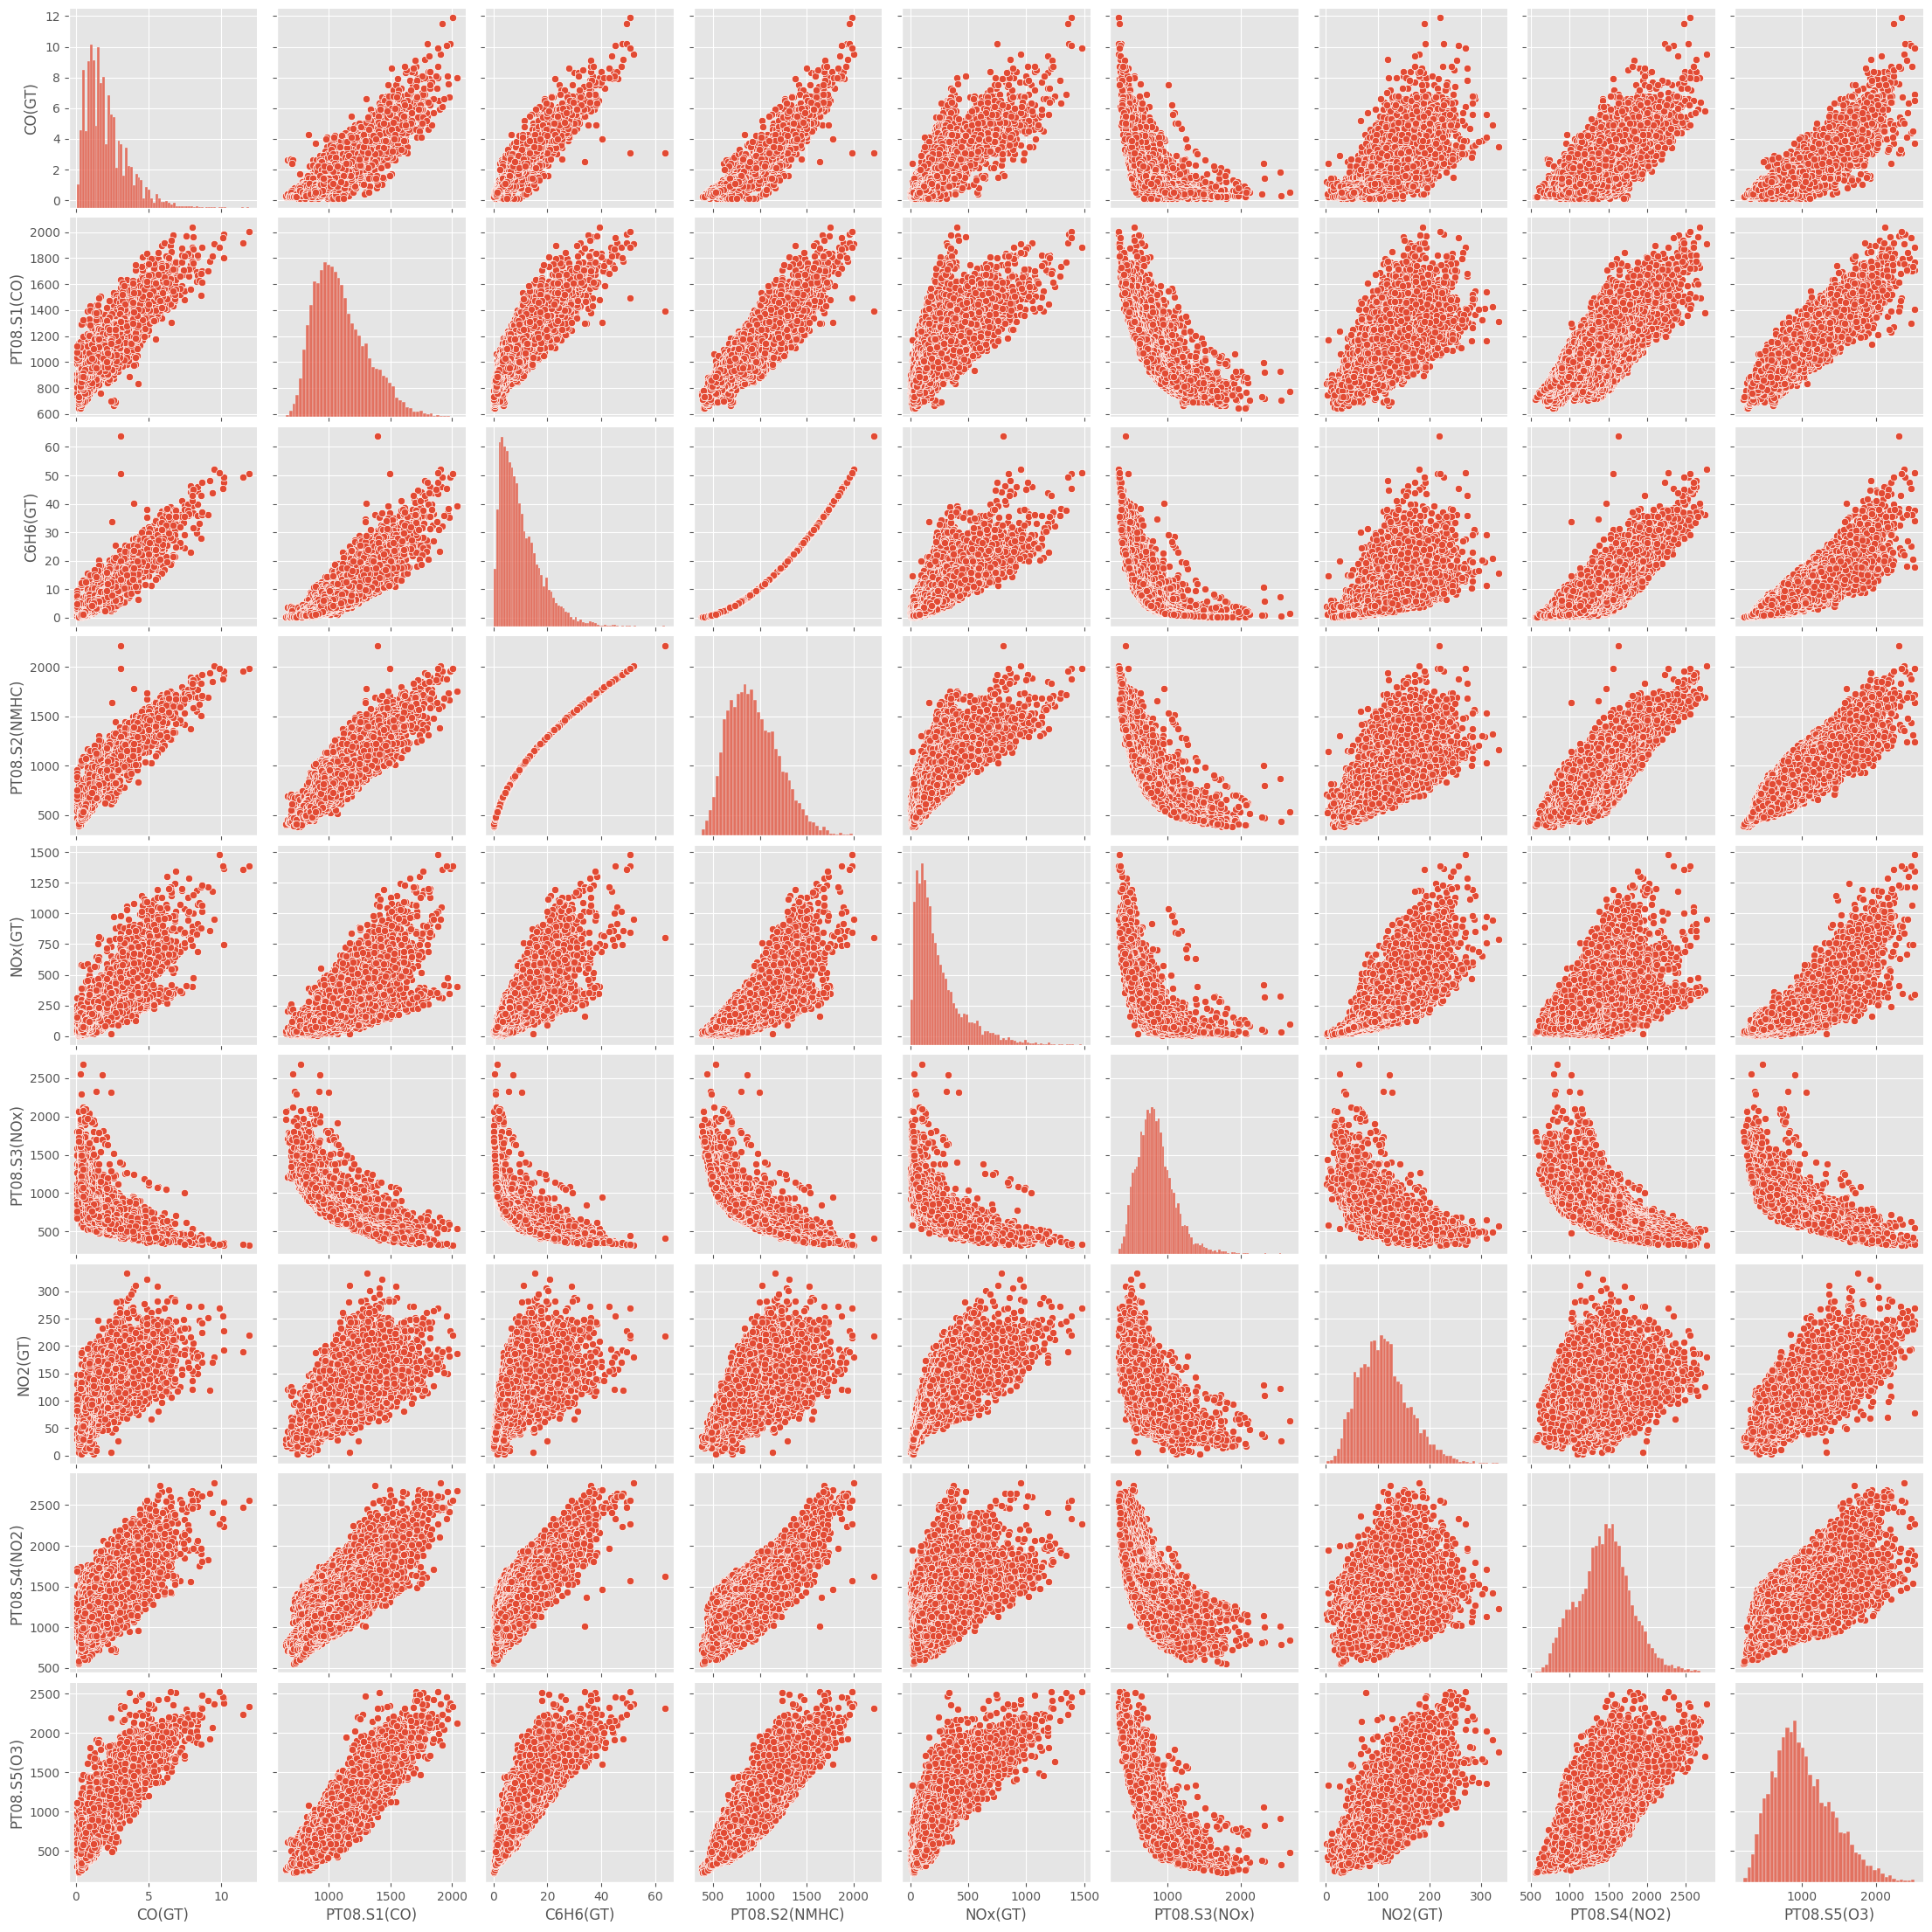

In [ ]:
sns.pairplot(df_top_corr);

Among all the correlations we can see strongly positively correlated pair: our target and PT08.S2(NMHC).\
On the plot below we can see how their relationship fits a linear regression.

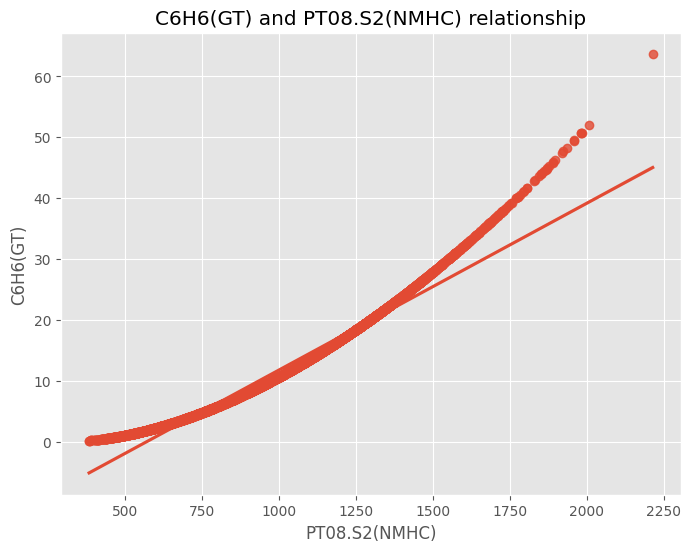

In [ ]:
regression_fit('PT08.S2(NMHC)', 'C6H6(GT)', df);

The line looks like a section of a parabola.

## Univariate analysis

### Target variable analysis

Target variable have to be transformed in order to fit the normal distribution. It is a necessary condition for further analysis of residuals that tells us how good our model fits the data.

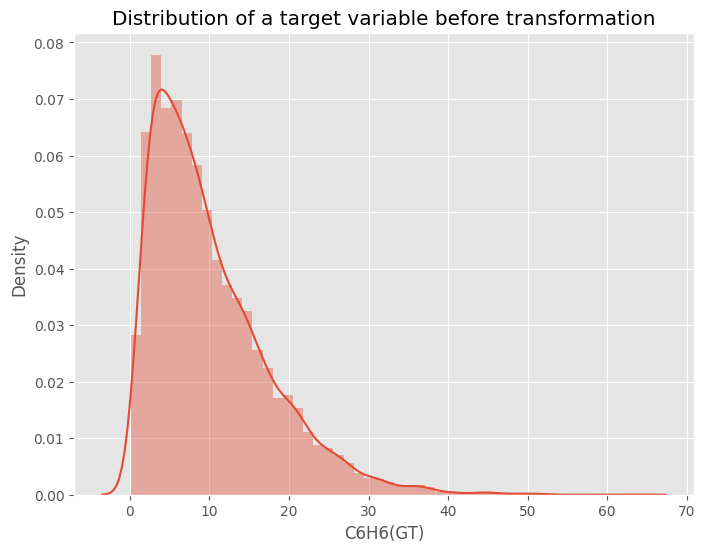

In [ ]:
# Plot distribution of the target before transformation
ax = sns.distplot(df['C6H6(GT)'], norm_hist=True)
ax.set_title('Distribution of a target variable before transformation');

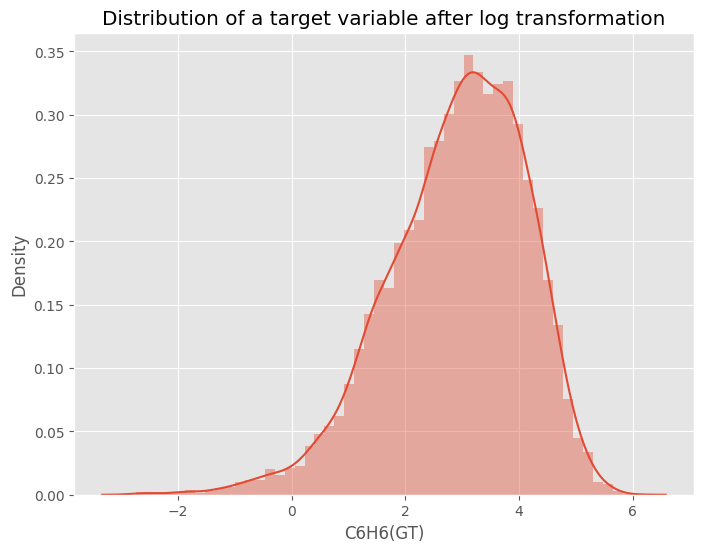

In [ ]:
# Plot distribution of the target after the log transformation
ax = sns.distplot(np.log2(df['C6H6(GT)']), norm_hist=True)
ax.set_title('Distribution of a target variable after log transformation');

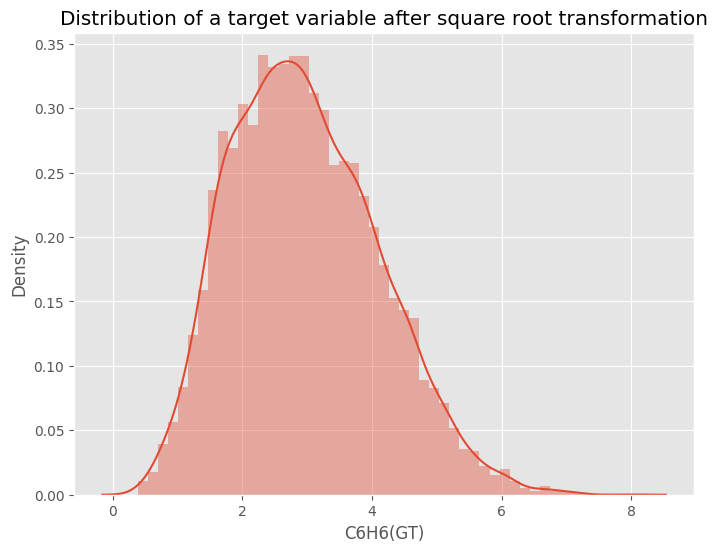

In [ ]:
# Plot distribution of the target after the sguare root transformation
ax = sns.distplot(np.sqrt(df['C6H6(GT)']), norm_hist=True)
ax.set_title('Distribution of a target variable after square root transformation');

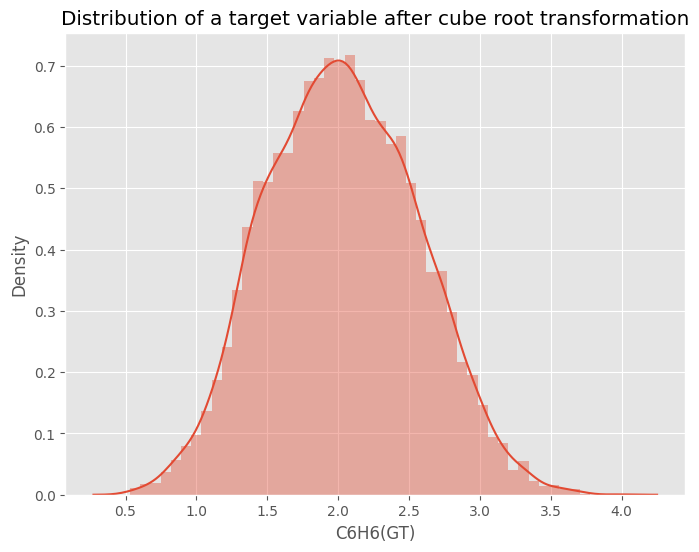

In [ ]:
# Plot distribution of the target after the cube root transformation
ax = sns.distplot(np.cbrt(df['C6H6(GT)']), norm_hist=True)
ax.set_title('Distribution of a target variable after cube root transformation');

Cube root tranformation suits best for the target transformation to get it normally distributed.

### Outlier analysis

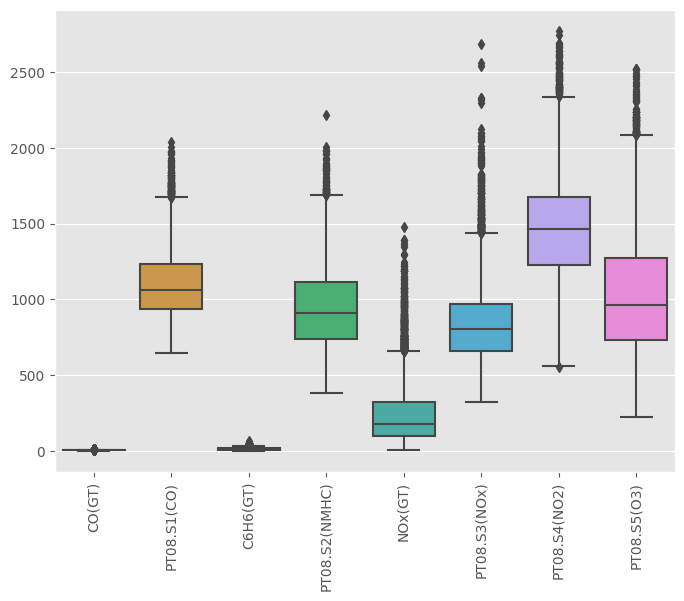

In [ ]:
# Plot boxplots of highly correlated variables to check for outliers
ax = sns.boxplot(data=df_top_corr)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

A lot of variables have outliers.\
To closer look at skewness of variables let's plot histograms.

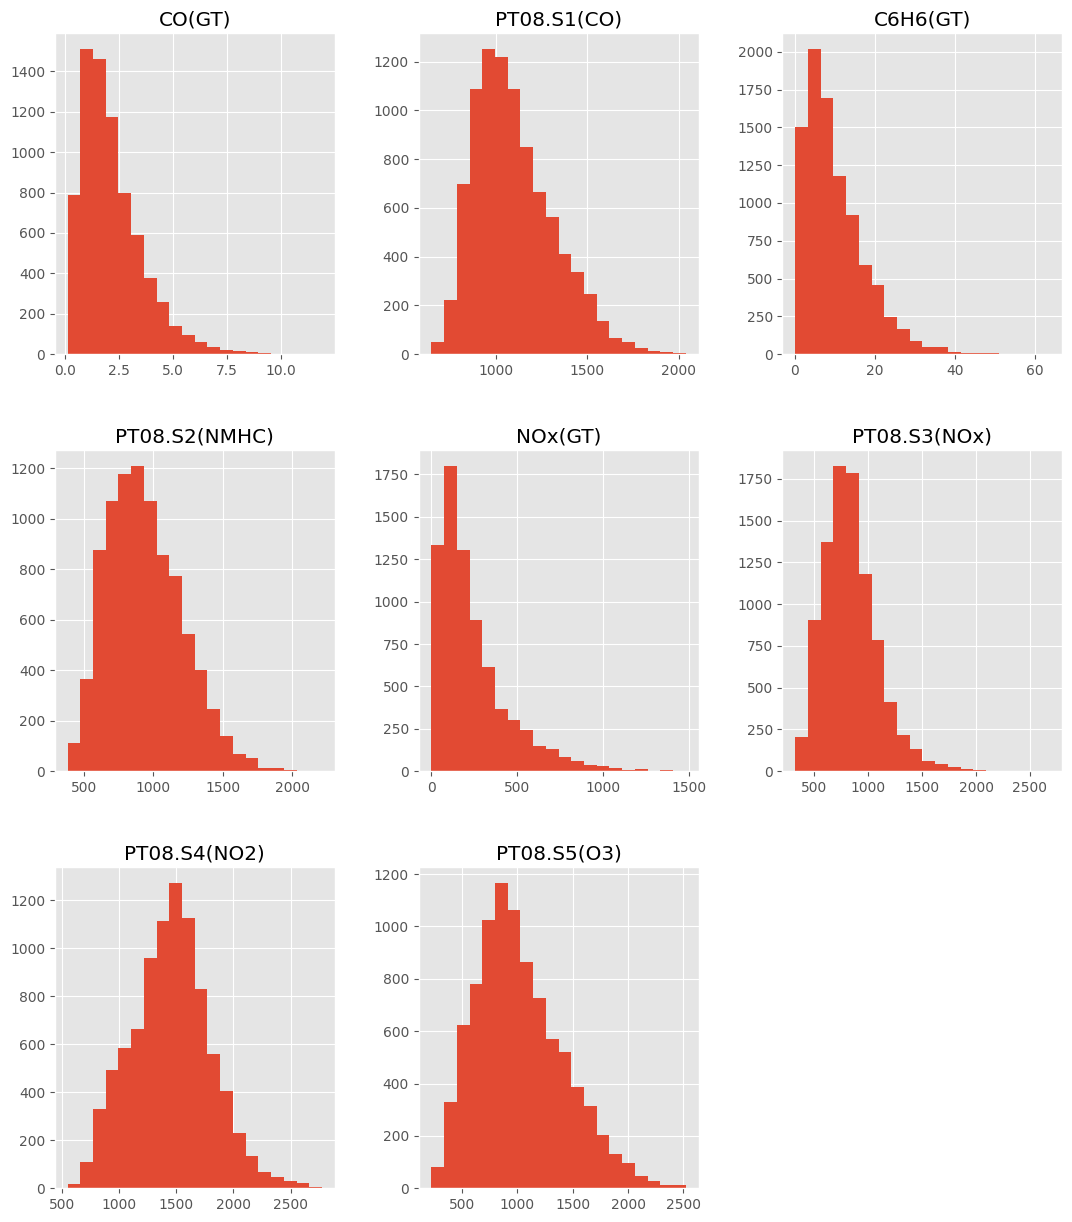

In [ ]:
# Plot histograms of each variable
df_top_corr.hist(figsize=(13, 15), bins=20);

Let's find lower and upper limits for values that are not considered outliers.

In [ ]:
Q1 = df['CO(GT)'].quantile(0.25)
Q3 = df['CO(GT)'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

upper limit: 5.35


In [ ]:
df['CO(GT)'].sort_values(ascending=False)

DateTime
2004-11-23 19:00:00    11.9
2004-11-23 20:00:00    11.5
2004-11-17 18:00:00    10.2
2004-11-23 18:00:00    10.2
2004-11-26 18:00:00    10.1
                       ... 
2005-03-23 04:00:00     NaN
2005-03-26 04:00:00     NaN
2005-03-29 04:00:00     NaN
2005-04-01 04:00:00     NaN
2005-04-04 04:00:00     NaN
Name: CO(GT), Length: 8991, dtype: float64

In [ ]:
Q1 = df['PT08.S1(CO)'].quantile(0.25)
Q3 = df['PT08.S1(CO)'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
print('lower limit:', lower_limit)

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

lower limit: 495.0
upper limit: 1673.0


In [ ]:
df['PT08.S1(CO)'].sort_values()

DateTime
2004-11-14 08:00:00     647.25
2004-11-14 07:00:00     648.75
2004-11-14 06:00:00     654.75
2004-11-19 22:00:00     666.75
2004-11-14 11:00:00     667.00
                        ...   
2004-03-17 19:00:00    1972.50
2004-03-17 20:00:00    1974.75
2004-11-23 18:00:00    1982.25
2004-11-23 19:00:00    2007.75
2004-03-15 19:00:00    2039.75
Name: PT08.S1(CO), Length: 8991, dtype: float64

In [ ]:
Q1 = df['C6H6(GT)'].quantile(0.25)
Q3 = df['C6H6(GT)'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

upper limit: 28.315781396708502


In [ ]:
df['C6H6(GT)'].sort_values()

DateTime
2005-01-26 05:00:00     0.149048
2005-01-25 06:00:00     0.149048
2005-03-01 03:00:00     0.164946
2005-01-25 05:00:00     0.171968
2005-03-01 04:00:00     0.181525
                         ...    
2004-11-23 19:00:00    50.632826
2004-11-22 09:00:00    50.672819
2004-12-13 18:00:00    50.779533
2004-10-26 18:00:00    52.054064
2004-11-22 10:00:00    63.741476
Name: C6H6(GT), Length: 8991, dtype: float64

In [ ]:
Q1 = df['PT08.S2(NMHC)'].quantile(0.25)
Q3 = df['PT08.S2(NMHC)'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
print('lower limit:', lower_limit)

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

lower limit: 161.5625
upper limit: 1689.0625


In [ ]:
df['PT08.S2(NMHC)'].sort_values()

DateTime
2005-01-26 05:00:00     383.25
2005-01-25 06:00:00     383.25
2005-03-01 03:00:00     386.75
2005-01-25 05:00:00     388.25
2005-03-01 04:00:00     390.25
                        ...   
2004-11-23 19:00:00    1980.25
2004-11-22 09:00:00    1981.00
2004-12-13 18:00:00    1983.00
2004-10-26 18:00:00    2006.75
2004-11-22 10:00:00    2214.00
Name: PT08.S2(NMHC), Length: 8991, dtype: float64

2214.00 is an outlier that stands out among the other outliers. We should remove it.

In [ ]:
Q1 = df['NOx(GT)'].quantile(0.25)
Q3 = df['NOx(GT)'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

upper limit: 657.0


In [ ]:
df['NOx(GT)'].sort_values(ascending=False)

DateTime
2004-12-13 18:00:00    1479.0
2004-11-26 18:00:00    1389.0
2004-11-23 19:00:00    1389.0
2004-11-23 18:00:00    1369.0
2004-11-23 20:00:00    1358.0
                        ...  
2005-03-07 03:00:00       NaN
2005-03-08 03:00:00       NaN
2005-03-09 03:00:00       NaN
2005-03-10 03:00:00       NaN
2005-03-10 13:00:00       NaN
Name: NOx(GT), Length: 8991, dtype: float64

In [ ]:
Q1 = df['PT08.S3(NOx)'].quantile(0.25)
Q3 = df['PT08.S3(NOx)'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
print('lower limit:', lower_limit)

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

lower limit: 190.8125
upper limit: 1436.3125


In [ ]:
df['PT08.S3(NOx)'].sort_values()

DateTime
2004-11-23 18:00:00     322.00
2004-11-23 19:00:00     324.50
2004-10-26 18:00:00     325.25
2004-11-04 18:00:00     328.00
2005-03-24 20:00:00     329.75
                        ...   
2004-12-10 08:00:00    2327.00
2004-12-10 04:00:00    2330.75
2004-12-10 10:00:00    2541.50
2004-12-10 05:00:00    2559.25
2004-12-10 07:00:00    2682.75
Name: PT08.S3(NOx), Length: 8991, dtype: float64

In [ ]:
Q1 = df['NO2(GT)'].quantile(0.25)
Q3 = df['NO2(GT)'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

upper limit: 234.5


In [ ]:
df['NO2(GT)'].sort_values(ascending=False)

DateTime
2005-02-03 11:00:00    332.6
2005-02-03 10:00:00    321.6
2005-02-05 09:00:00    310.1
2005-02-03 09:00:00    309.2
2005-02-04 08:00:00    306.4
                       ...  
2005-03-07 03:00:00      NaN
2005-03-08 03:00:00      NaN
2005-03-09 03:00:00      NaN
2005-03-10 03:00:00      NaN
2005-03-10 13:00:00      NaN
Name: NO2(GT), Length: 8991, dtype: float64

In [ ]:
Q1 = df['PT08.S4(NO2)'].quantile(0.25)
Q3 = df['PT08.S4(NO2)'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
print('lower limit:', lower_limit)

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

lower limit: 556.3125
upper limit: 2343.8125


In [ ]:
df['PT08.S4(NO2)'].sort_values()

DateTime
2005-03-01 04:00:00     551.00
2005-03-01 03:00:00     559.25
2005-03-01 05:00:00     560.50
2005-03-01 06:00:00     579.00
2005-03-02 01:00:00     601.00
                        ...   
2004-03-15 19:00:00    2679.00
2004-04-21 08:00:00    2684.00
2004-06-09 08:00:00    2690.50
2004-06-08 08:00:00    2746.00
2004-10-26 18:00:00    2775.00
Name: PT08.S4(NO2), Length: 8991, dtype: float64

In [ ]:
Q1 = df['PT08.S5(O3)'].quantile(0.25)
Q3 = df['PT08.S5(O3)'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
print('upper limit:', Q3 + 1.5 * IQR)

upper limit: 2086.375


In [ ]:
df['PT08.S5(O3)'].sort_values()

DateTime
2005-03-01 04:00:00     221.00
2005-03-01 05:00:00     224.75
2005-03-01 03:00:00     226.50
2005-03-01 06:00:00     232.00
2005-02-28 05:00:00     252.00
                        ...   
2005-02-12 23:00:00    2493.50
2004-11-22 19:00:00    2515.25
2004-11-01 01:00:00    2519.25
2004-11-22 20:00:00    2522.25
2004-12-13 18:00:00    2522.75
Name: PT08.S5(O3), Length: 8991, dtype: float64

Although we have a lot of values that are statistically outliers, those values are real data that tell us about level of pollution. I think we shouldn't remove them.

## Train/Test Split

In [ ]:
df_top_corr.shape

(8991, 9)

To prevent data leakage split the data before the data preparation.\
Splitting data we don't shuffle it because it's time-dependent.

In [ ]:
# Find an index boundary for train/test set (80/20 train/test split)
df_top_corr.shape[0] - (df_top_corr.shape[0]/5)

7192.8

In [ ]:
# Train/test split
train, test = df_top_corr.iloc[:7192,:], df_top_corr.iloc[7192:,:]
train.shape, test.shape

((7192, 9), (1799, 9))

## Reducing number of features + Train/Test and X/y Split

We select only moderately and strongly correlated variables, i.e. correlation > 0.5.\
Not including a low correlated feature can help prevent overfitting.

In [ ]:
# Make a list of features, remove a target
top_corr_features = list(top_corr.columns)
top_corr_features.remove(TARGET)

In [ ]:
# Split a train subset into features matrix and a target vector
X_train, y_train = train.drop(TARGET, axis = 1), train[TARGET]

In [ ]:
# Selet only strongly correlated features for a train subset
X_train_top = X_train[top_corr_features]

In [ ]:
# Split a test subset into features matrix and a target vector
X_test, y_test = test.drop(TARGET, axis = 1), test[TARGET]

In [ ]:
# Selet only strongly correlated features for a test subset
X_test_top = X_test[top_corr_features]

## Fill NAs

Since the dataset's measurements are time-dependent we fill NaN values using `interpolate` function from Pandas with `method='time'`.

In [ ]:
X_train_top = X_train_top.interpolate(method='time')
X_test_top = X_test_top.interpolate(method='time')

## Scaling

Since there are outliers in the data set we should scale data with method that is robust to outliers (for example, RobustScaler). But let's conduct an experiment to choose an appropriate scaler. Question is: what scaler allows preserving a strong linear correlation between a target and the most correlated with it variable.

In [ ]:
X_train_robust = pd.DataFrame(RobustScaler().fit_transform(X_train_top),
                              columns=top_corr_features)

X_train_standard = pd.DataFrame(StandardScaler().fit_transform(X_train_top),
                              columns=top_corr_features)

X_train_minmax = pd.DataFrame(MinMaxScaler().fit_transform(X_train_top),
                              columns=top_corr_features)

Let's plot relationship of a target with the strongest correlated variable scaled by different scalers.

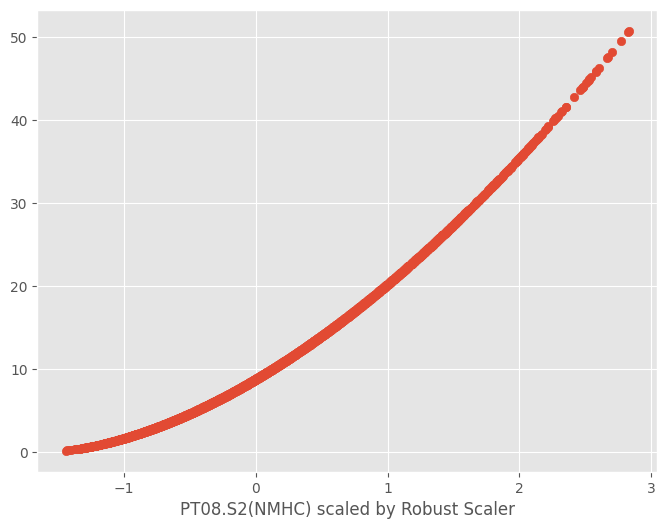

In [ ]:
plt.scatter(x=X_train_robust['PT08.S2(NMHC)'], y=y_train);
plt.xlabel('PT08.S2(NMHC) scaled by Robust Scaler');

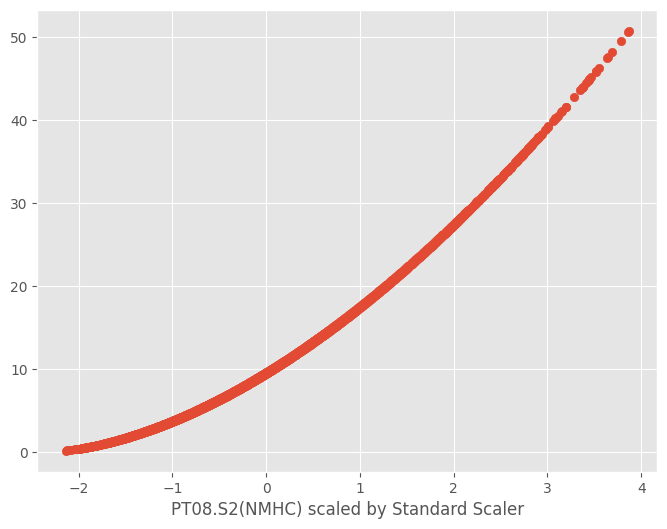

In [ ]:
plt.scatter(x = X_train_standard['PT08.S2(NMHC)'], y = y_train);
plt.xlabel('PT08.S2(NMHC) scaled by Standard Scaler');

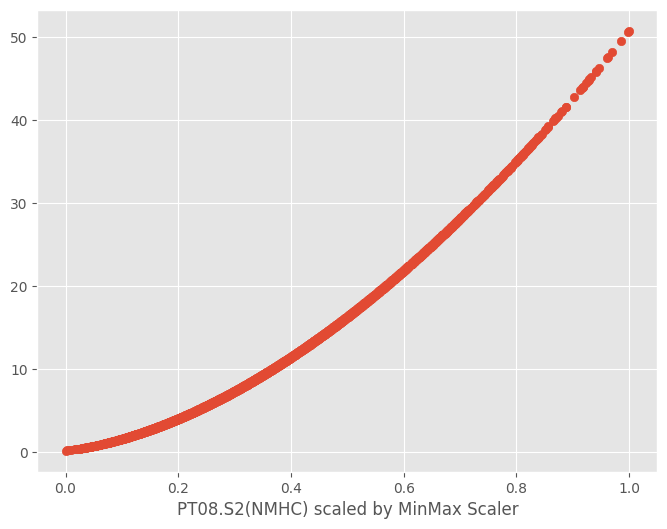

In [ ]:
plt.scatter(x = X_train_minmax['PT08.S2(NMHC)'], y = y_train);
plt.xlabel('PT08.S2(NMHC) scaled by MinMax Scaler');

No difference. But what if we try to make our line straight and square a variable.

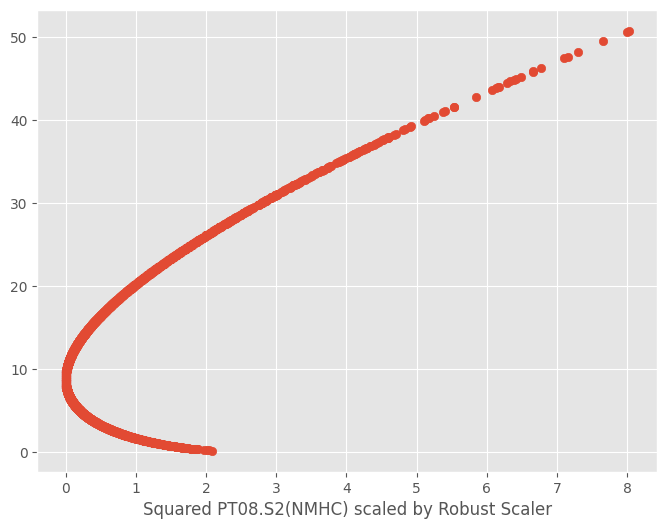

In [ ]:
plt.scatter(x = (X_train_robust['PT08.S2(NMHC)'])**2, y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by Robust Scaler');

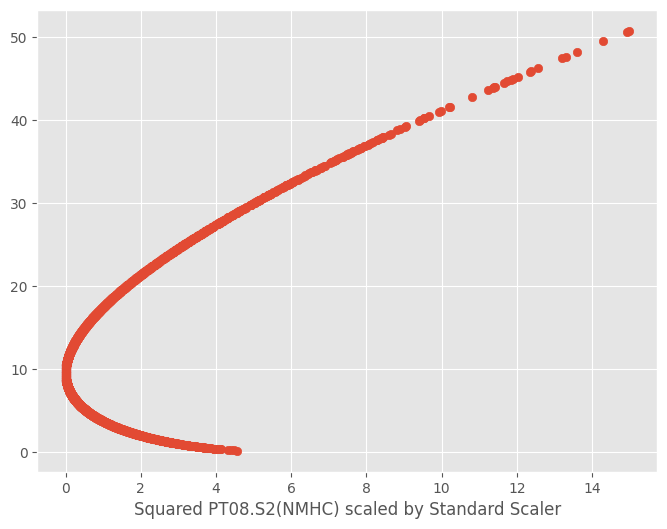

In [ ]:
plt.scatter(x = (X_train_standard['PT08.S2(NMHC)'])**2, y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by Standard Scaler');

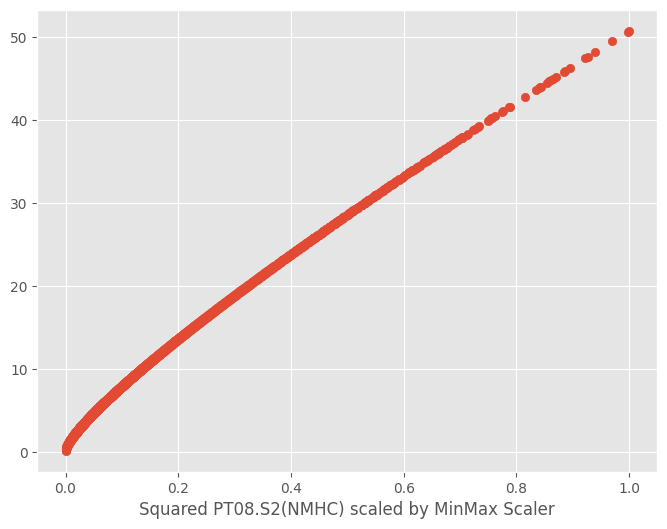

In [ ]:
plt.scatter(x = (X_train_minmax['PT08.S2(NMHC)'])**2, y = y_train);
plt.xlabel('Squared PT08.S2(NMHC) scaled by MinMax Scaler');

MinMax Scaler happened to be the most efficient scaler.

## Feature engineering (polynomial features transformation) & Features transormation

Since a variable that is the most correlated with a target forms a strong linear correlation when squared let's generate second degree polynomial features.

In [ ]:
# Create a class for mapping Pandas dataframe columns to the Sklearn transformations
mapper = DataFrameMapper([
    (top_corr_features, MinMaxScaler()),
    (top_corr_features, PolynomialFeatures(2))
], df_out=True)

Also we have to transform a target variable to cube root of it to have a predictand normally distributed. Linearizing the target allows obtaining better prediction.

In [ ]:
y_train_cbrt = pd.Series(np.cbrt(y_train))
y_test_cbrt = pd.Series(np.cbrt(y_test))

# Linear Regression

## Baseline & Metrics

In [ ]:
# Pipeline of transforms with an estimator
pipeline = Pipeline([
    ('mapper', mapper),  # scaler, poly
    ('estimator', LinearRegression())
])

**RMSE** shows how far predictions are from true values in units of measurements.\
 **R-squared (R2)** represents how much variance for a target  is explained by independent variables.

In [ ]:
scores, colnames, pred_test = evaluate_model(
    X_train_top, X_test_top, y_train_cbrt, y_test_cbrt, pipeline
    )
scores

train_RMSE  train_R2  test_RMSE   test_R2
0    0.010157  0.999614   0.023955  0.997966

Test RMSE is twice as big as train RMSE. It is an idication of overfitting.

In [ ]:
tscv = TimeSeriesSplit()  # n_splits=5 is a default parameter
CV_score = cross_val_score(pipeline, X_train_top, y_train_cbrt, cv=tscv,
                           scoring='neg_root_mean_squared_error')

print('Train RMSE cross-validation scores:')
print(CV_score*-1)
print('-'*30)
print('Train RMSE average cross-validation scores:')
print(CV_score.mean()*-1)

Train RMSE cross-validation scores:
[0.01123473 0.01281552 0.01452233 0.0163693  0.02159131]
------------------------------
Train RMSE average cross-validation scores:
0.01530663950787744


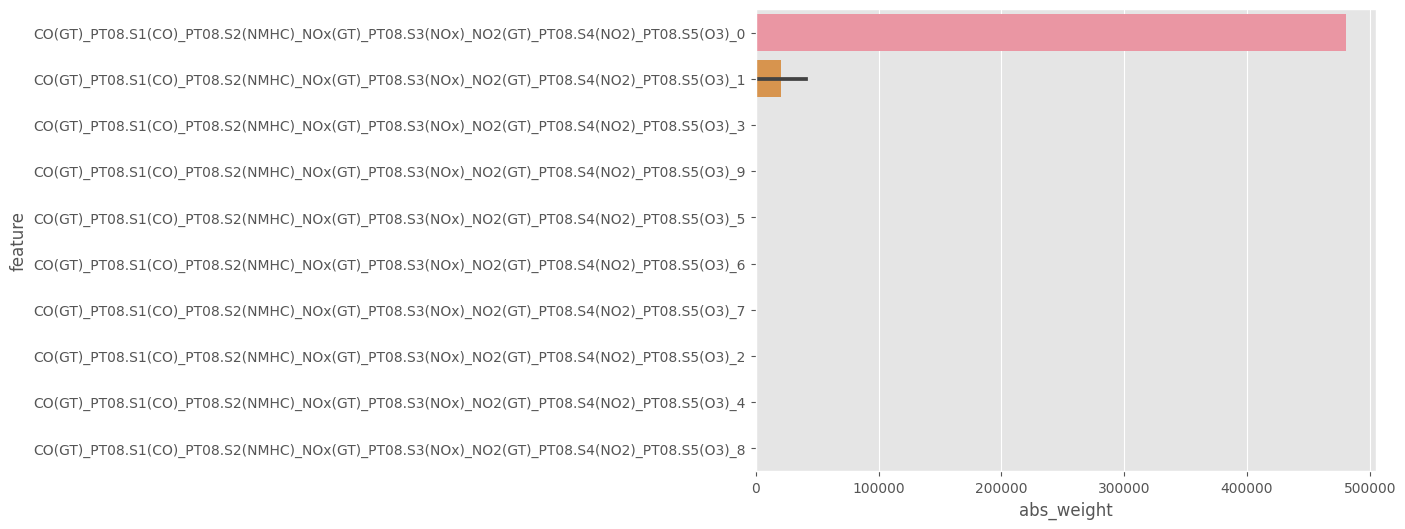

In [ ]:
plot_importance(pipeline.named_steps['estimator'], colnames)

Metrics are not bad but let's perform residual analysis to ensure that out model is good.

## Hyperparameters tuning for a regularized regression

### ElasticNet

In [ ]:
pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', ElasticNet(random_state=SEED))
])

In [ ]:
%%time
gs_elastic = GridSearchCV(pipeline, {
    'estimator__alpha': np.linspace(0, 300, 10),
    'estimator__l1_ratio': np.arange(0, 1.1, 0.1)
},
                  n_jobs=-1,
                  scoring=['neg_mean_squared_error', 'r2'],
                  refit='neg_mean_squared_error',
                  cv=tscv,
                  verbose=10)

gs_elastic.fit(X_train_top, np.cbrt(y_train));

Fitting 5 folds for each of 110 candidates, totalling 550 fits
CPU times: user 3.88 s, sys: 517 ms, total: 4.4 s
Wall time: 2min 41s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('mapper',
                                        DataFrameMapper(df_out=True,
                                                        drop_cols=[],
                                                        features=[(['CO(GT)',
                                                                    'PT08.S1(CO)',
                                                                    'PT08.S2(NMHC)',
                                                                    'NOx(GT)',
                                                                    'PT08.S3(NOx)',
                                                                    'NO2(GT)',
                                                                    'PT08.S4(NO2)',
                                                                    'PT08.S5(O3)'],
                                                                   MinMaxScaler()),
                                                                  (['CO(GT)',
                                                                    'PT08.S1(CO)',
                                                                    'PT08.S2(NMHC)',
                                                                    'NOx(GT)',
                                                                    'PT08...
                                                                   PolynomialFeatures())])),
                                       ('estimator',
                                        ElasticNet(random_state=42))]),
             n_jobs=-1,
             param_grid={'estimator__alpha': array([  0.        ,  33.33333333,  66.66666667, 100.        ,
       133.33333333, 166.66666667, 200.        , 233.33333333,
       266.66666667, 300.        ]),
                         'estimator__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'], verbose=10)

   train_RMSE  train_R2  test_RMSE   test_R2
0    0.012761  0.999391   0.030036  0.996803


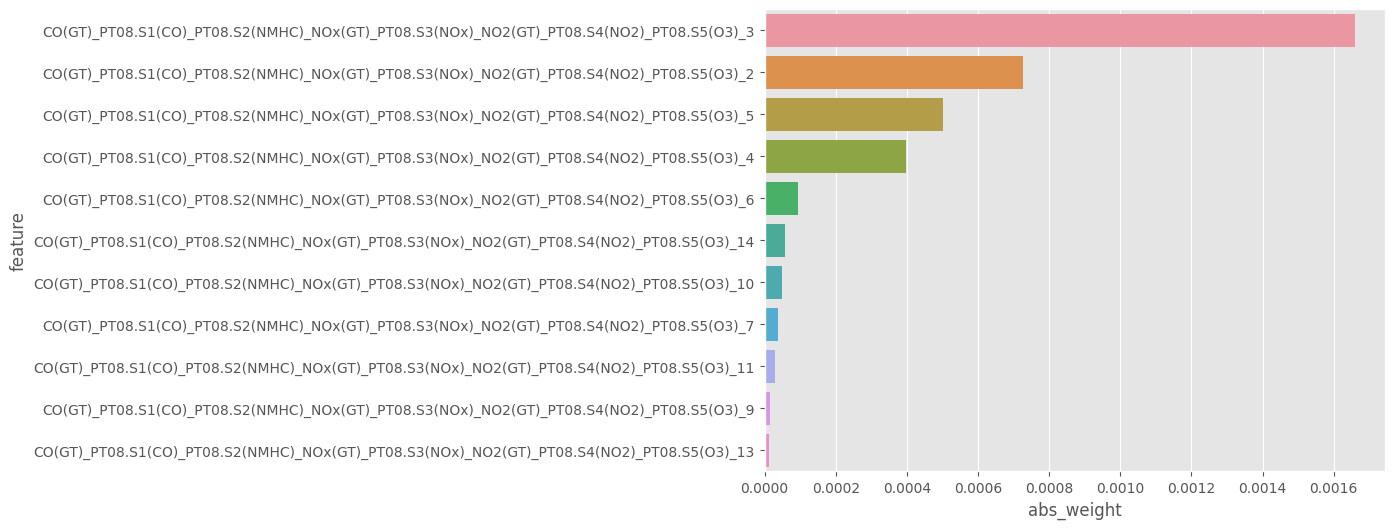

In [ ]:
pipeline = gs_elastic.best_estimator_
scores, colnames, pred_test = evaluate_model(
    X_train_top, X_test_top, y_train_cbrt, y_test_cbrt, pipeline
    )

print(scores)

plot_importance(pipeline.named_steps['estimator'], colnames)

Metrics are worse than those of a basic linear regression.

### Ridge

In [ ]:
pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', Ridge(random_state=SEED))
])

In [ ]:
%%time
gs_ridge = GridSearchCV(pipeline, {
    'estimator__alpha': np.linspace(0, 100, 10)
},
                  n_jobs=-1,
                  scoring=['neg_mean_squared_error', 'r2'],
                  refit='neg_mean_squared_error',
                  cv=tscv)

gs_ridge.fit(X_train_top, np.cbrt(y_train));

CPU times: user 398 ms, sys: 87.5 ms, total: 485 ms
Wall time: 12.1 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('mapper',
                                        DataFrameMapper(df_out=True,
                                                        drop_cols=[],
                                                        features=[(['CO(GT)',
                                                                    'PT08.S1(CO)',
                                                                    'PT08.S2(NMHC)',
                                                                    'NOx(GT)',
                                                                    'PT08.S3(NOx)',
                                                                    'NO2(GT)',
                                                                    'PT08.S4(NO2)',
                                                                    'PT08.S5(O3)'],
                                                                   MinMaxScaler()),
                                                                  (['CO(GT)',
                                                                    'PT08.S1(CO)',
                                                                    'PT08.S2(NMHC)',
                                                                    'NOx(GT)',
                                                                    'PT08.S3(NOx)',
                                                                    'NO2(GT)',
                                                                    'PT08.S4(NO2)',
                                                                    'PT08.S5(O3)'],
                                                                   PolynomialFeatures())])),
                                       ('estimator', Ridge(random_state=42))]),
             n_jobs=-1,
             param_grid={'estimator__alpha': array([  0.        ,  11.11111111,  22.22222222,  33.33333333,
        44.44444444,  55.55555556,  66.66666667,  77.77777778,
        88.88888889, 100.        ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

   train_RMSE  train_R2  test_RMSE   test_R2
0    0.010171  0.999613   0.024042  0.997952


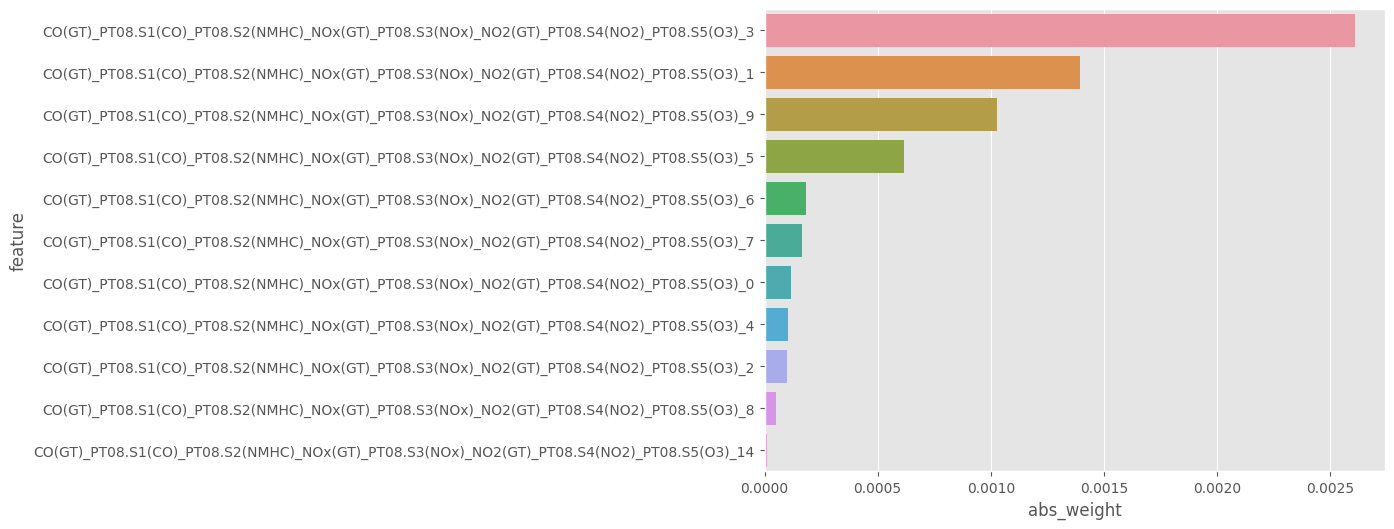

In [ ]:
pipeline = gs_ridge.best_estimator_
scores, colnames, pred_test = evaluate_model(
    X_train_top, X_test_top, y_train_cbrt, y_test_cbrt, pipeline
    )

print(scores)

plot_importance(pipeline.named_steps['estimator'], colnames)

Metrics are slightly worse than those of a basic linear regression but better than those of the elastic net regression.

### Lasso

In [ ]:
pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', Lasso(random_state=SEED))
])

In [ ]:
%%time
gs_lasso = GridSearchCV(pipeline, {
    'estimator__alpha': np.linspace(0, 100, 10)
},
                  n_jobs=-1,
                  scoring=['neg_mean_squared_error', 'r2'],
                  refit='neg_mean_squared_error',
                  cv=tscv,
                  verbose=10)

gs_lasso.fit(X_train_top, np.cbrt(y_train));

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 864 ms, sys: 206 ms, total: 1.07 s
Wall time: 13.3 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('mapper',
                                        DataFrameMapper(df_out=True,
                                                        drop_cols=[],
                                                        features=[(['CO(GT)',
                                                                    'PT08.S1(CO)',
                                                                    'PT08.S2(NMHC)',
                                                                    'NOx(GT)',
                                                                    'PT08.S3(NOx)',
                                                                    'NO2(GT)',
                                                                    'PT08.S4(NO2)',
                                                                    'PT08.S5(O3)'],
                                                                   MinMaxScaler()),
                                                                  (['CO(GT)',
                                                                    'PT08.S1(CO)',
                                                                    'PT08.S2(NMHC)',
                                                                    'NOx(GT)',
                                                                    'PT08.S3(NOx)',
                                                                    'NO2(GT)',
                                                                    'PT08.S4(NO2)',
                                                                    'PT08.S5(O3)'],
                                                                   PolynomialFeatures())])),
                                       ('estimator', Lasso(random_state=42))]),
             n_jobs=-1,
             param_grid={'estimator__alpha': array([  0.        ,  11.11111111,  22.22222222,  33.33333333,
        44.44444444,  55.55555556,  66.66666667,  77.77777778,
        88.88888889, 100.        ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'], verbose=10)

   train_RMSE  train_R2  test_RMSE   test_R2
0     0.01322  0.999346   0.032112  0.996346


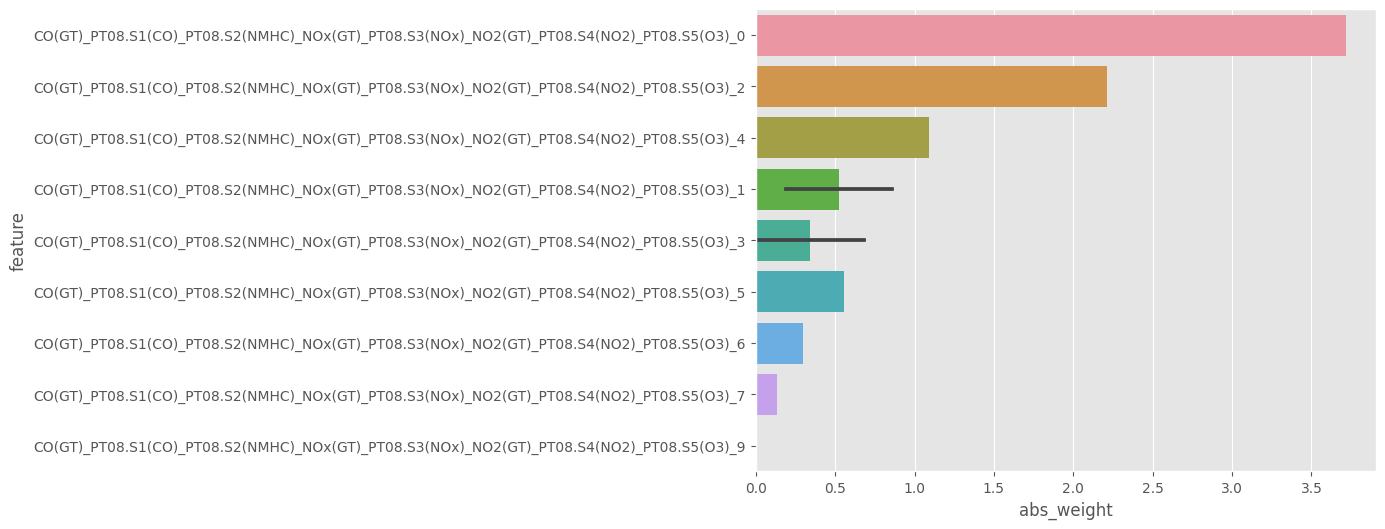

In [ ]:
pipeline = gs_lasso.best_estimator_
scores, colnames, pred_test = evaluate_model(
    X_train_top, X_test_top, y_train_cbrt, y_test_cbrt, pipeline
    )

print(scores)

plot_importance(pipeline.named_steps['estimator'], colnames)

Metrics are worse than those of any regression than we tried in this project.\
Taking in consideration residual plot, let's add a degree to polynomial features.





## Feature engineering (polynomial features transformation)

I added a forth-degree polynomial because a third-degree one didn't give a desired result.

In [ ]:
mapper = DataFrameMapper([
    (top_corr_features, MinMaxScaler()),
    (top_corr_features, PolynomialFeatures(3))
], df_out=True)

pipeline = Pipeline([
    ('mapper', mapper),
    ('estimator', LinearRegression())
])

In [ ]:
scores, colnames, pred_test = evaluate_model(
    X_train_top, X_test_top, y_train_cbrt, y_test_cbrt, pipeline
    )
scores

train_RMSE  train_R2  test_RMSE   test_R2
0    0.002624  0.999974   0.007601  0.999795

In [ ]:
tscv = TimeSeriesSplit()  # n_splits=5 is a default parameter
CV_score = cross_val_score(pipeline, X_train_top, y_train_cbrt, cv=tscv,
                           scoring='neg_root_mean_squared_error')

print('Train RMSE cross-validation scores:')
print(CV_score*-1)
print('-'*30)
print('Train RMSE average cross-validation scores:')
print(CV_score.mean()*-1)

Train RMSE cross-validation scores:
[0.00409757 0.00636997 0.00991873 0.00688339 0.02124362]
------------------------------
Train RMSE average cross-validation scores:
0.009702655765344752


Let's calculate metrics.

In [ ]:
rmse_transformed_train = np.sqrt(
    mean_squared_error(np.power(y_train_cbrt, 3),
                       np.power(pipeline.predict(X_train_top), 3))
    )
print(f'\nRMSE Train Score Transformed: {rmse_transformed_train}')


RMSE Train Score Transformed: 0.041806799151142264


In [ ]:
rmse_transformed_test = np.sqrt(
    mean_squared_error(np.power(y_test_cbrt, 3),
                       np.power(pipeline.predict(X_test_top), 3))
    )
print(f'\nRMSE Test Score Transformed: {rmse_transformed_test}')


RMSE Test Score Transformed: 0.0770975878014211
